In [8]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

# Cleaned dataset
df = pd.read_csv("data/drugreviews_clean.csv")

# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Basic preprocessing function
def preprocess_text(text):
    text = str(text).lower()                               # lowercase
    text = re.sub(r'[^a-z\s]', '', text)                   # remove punctuation
    tokens = text.split()                                  # tokenize
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    return " ".join(tokens)

df['clean_review'] = df['review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Preview
df[['review', 'clean_review']].head()

,review,clean_review
0,"""It has no side effect, I take it in combinati...",side effect take combination bystolic mg fish oil
1,"""My son is halfway through his fourth week of ...",son halfway fourth week intuniv became concern...
2,"""I used to take another oral contraceptive, wh...",used take another oral contraceptive pill cycl...
3,"""This is my first time using any form of birth...",first time using form birth control im glad we...
4,"""Suboxone has completely turned my life around...",suboxone completely turned life around feel he...


In [9]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

# Apply sentiment scoring
df['sentiment_score'] = df['clean_review'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Classify into Positive / Neutral / Negative
def classify_sentiment(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

df['sentiment'] = df['sentiment_score'].apply(classify_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Toshiba\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [10]:
# First few reviews with their sentiment
print(df[['clean_review', 'sentiment_score', 'sentiment']].head(10))

# Summary of sentiment counts
print("\nSentiment distribution:")
print(df['sentiment'].value_counts())

# Percentage breakdown
print("\nSentiment percentage:")
print(df['sentiment'].value_counts(normalize=True) * 100)


                                        clean_review  sentiment_score  \
0  side effect take combination bystolic mg fish oil           0.0000   
1  son halfway fourth week intuniv became concern...           0.9068   
2  used take another oral contraceptive pill cycl...           0.7506   
3  first time using form birth control im glad we...           0.7184   
4  suboxone completely turned life around feel he...           0.9403   
5  nd day mg started work rock hard erections how...          -0.8779   
6  pulled cummed bit took plan b hours later took...           0.0000   
7  abilify changed life hope zoloft clonidine fir...          -0.9468   
8  nothing problems keppera constant shaking arms...          -0.1386   
9  pill many years doctor changed rx chateal effe...           0.8179   

  sentiment  
0   Neutral  
1  Positive  
2  Positive  
3  Positive  
4  Positive  
5  Negative  
6   Neutral  
7  Negative  
8  Negative  
9  Positive  

Sentiment distribution:
sentiment
Positiv

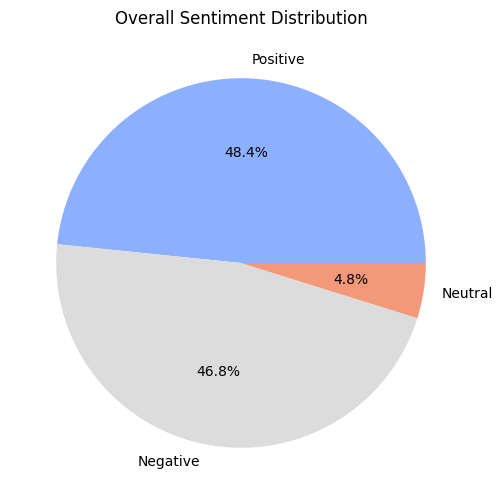

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the reviews that belong to each sentiment category
sentiment_counts = df['sentiment'].value_counts()

# Visualization of sentiment category
plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", 3))
plt.title("Overall Sentiment Distribution")
plt.show()

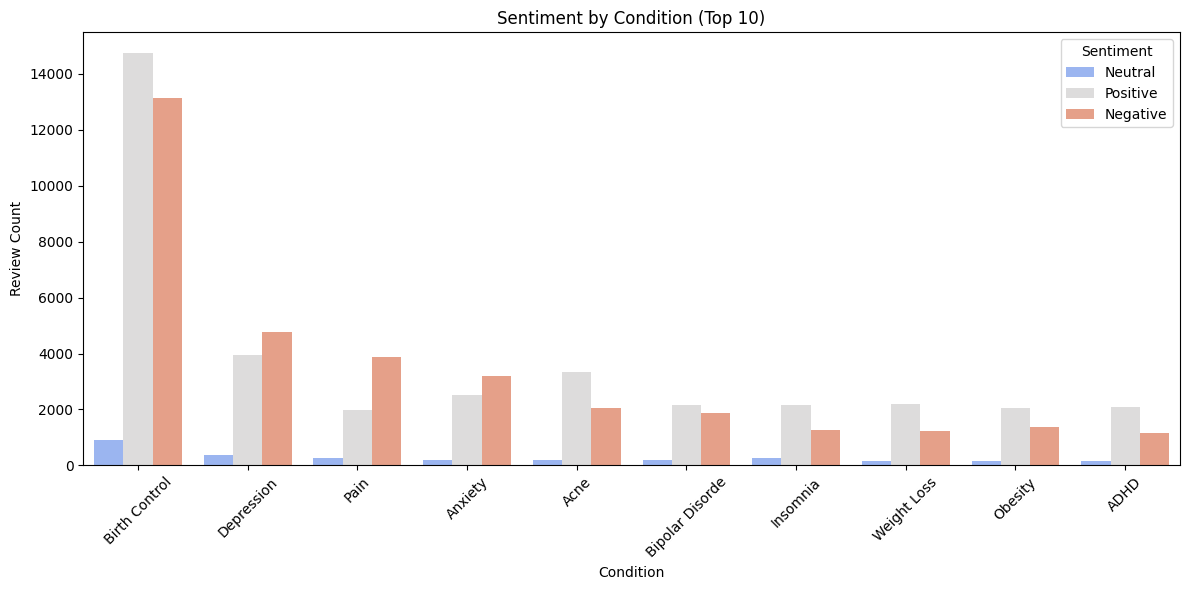

In [12]:
# Visualization of sentiment by condition
plt.figure(figsize=(12,6))
sns.countplot(data=df, x="condition", hue="sentiment", palette="coolwarm",
              order=df['condition'].value_counts().iloc[:10].index)  # top 10 conditions
plt.xticks(rotation=45)
plt.title("Sentiment by Condition (Top 10)")
plt.xlabel("Condition")
plt.ylabel("Review Count")
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()


In [10]:
from collections import Counter

# Most common words in negative reviews
neg_words = " ".join(df[df['sentiment']=="Negative"]['clean_review']).split()
neg_common = Counter(neg_words).most_common(15)

# Most common words in positive reviews
pos_words = " ".join(df[df['sentiment']=="Positive"]['clean_review']).split()
pos_common = Counter(pos_words).most_common(15)

# Print top words for each sentiment
print("Top Negative Words:", neg_common)
print("Top Positive Words:", pos_common)

Top Negative Words: [('pain', 34597), ('day', 28492), ('taking', 26368), ('im', 26064), ('side', 25496), ('mg', 22747), ('ive', 21947), ('years', 21646), ('take', 21620), ('started', 21459), ('effects', 21419), ('first', 20883), ('days', 20742), ('months', 20676), ('get', 20255)]
Top Positive Words: [('im', 27580), ('day', 25729), ('side', 25278), ('years', 23408), ('ive', 23297), ('taking', 23169), ('first', 22684), ('like', 22259), ('effects', 21256), ('months', 20898), ('take', 20839), ('get', 19811), ('mg', 19703), ('started', 19552), ('days', 18356)]


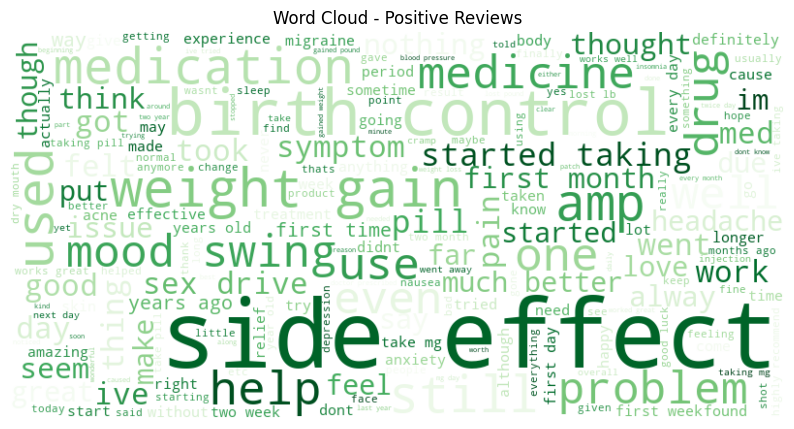

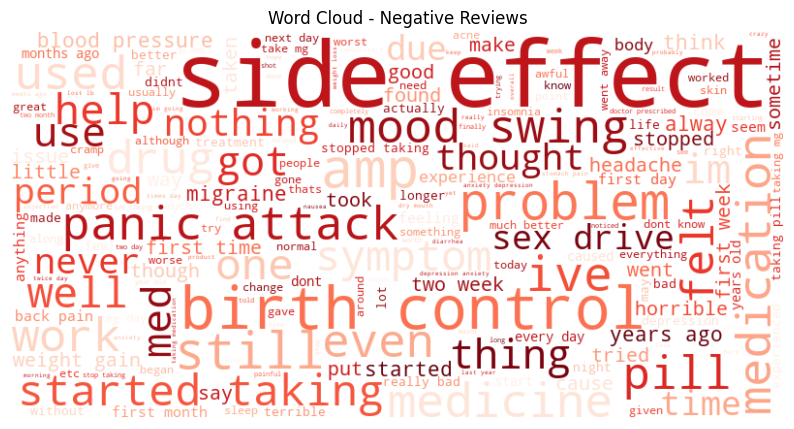

In [14]:
from wordcloud import WordCloud

# Positive reviews
pos_text = " ".join(df[df['sentiment']=="Positive"]['clean_review'])
wordcloud_pos = WordCloud(width=800, height=400, background_color="white", colormap="Greens").generate(pos_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Positive Reviews")
plt.show()

# Negative reviews
neg_text = " ".join(df[df['sentiment']=="Negative"]['clean_review'])
wordcloud_neg = WordCloud(width=800, height=400, background_color="white", colormap="Reds").generate(neg_text)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud - Negative Reviews")
plt.show()

<Figure size 1200x600 with 0 Axes>

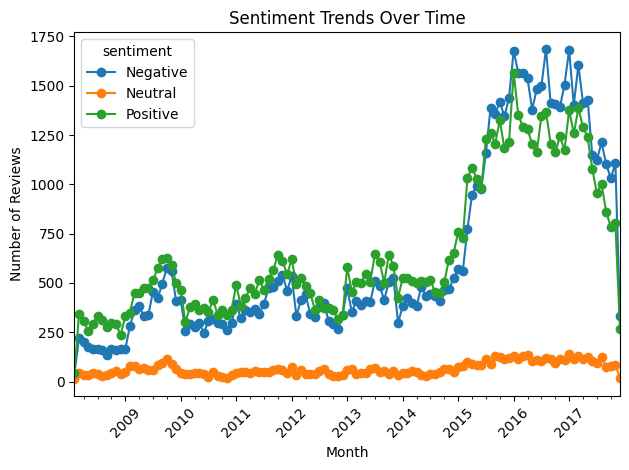

In [16]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year_month'] = df['date'].dt.to_period('M')

trend = df.groupby(['year_month', 'sentiment']).size().unstack().fillna(0)

# Visualize Sentiment trends over time
plt.figure(figsize=(12,6))
trend.plot(kind="line", marker="o")
plt.title("Sentiment Trends Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()